Shape: (1000, 15)
[0.00169034 0.00978576 0.01114108 0.03564451 0.00921554 0.13728193
 0.00105559 0.08591284 0.2987218  0.02303728 0.26604016 0.10231844
 0.01256621 0.0536246  0.19120615]


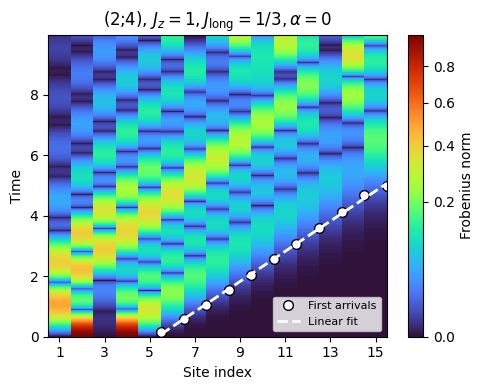

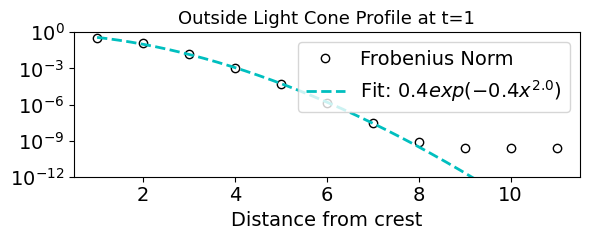

profile [3.16764738e-01 1.23455246e-01 1.65856239e-02 1.15465288e-03
 4.95375244e-05 1.44582699e-06 3.08424175e-08 7.31015248e-10
 2.45403697e-10 2.39186448e-10 2.39208653e-10]


In [21]:
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def load_mathematica_data(filename):
    """
    Load data from a Mathematica-style text file:
    {0.001707401450201651 + 0.*I, 5.646194622954682*^-9 + 0.*I, ...}
    Returns: 2D numpy array (rows = lines, cols = entries per line)
    """
    data = []
    with open(filename, "r") as f:
        for line in f:
            # Normalize Mathematica scientific notation: *^ -> e
            line = line.replace("*^", "e")

            # Remove curly braces
            line = line.strip().lstrip("{").rstrip("}")
            
            # Split by comma
            entries = line.split(",")
            
            # Extract real part (ignore imaginary part)
            row = []
            for e in entries:
                e = e.strip()
                # Remove the "+ 0.*I" if present
                e = e.split("+")[0].strip()
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)


# -----------------------------
# Example usage
# -----------------------------

# Define path to the data file
data_path = os.path.join("src", "N15B0LFIMHeffJlong03b1lc.txt")

# Load data from file; first column = time, rest = spatial density over time
raw_data = load_mathematica_data(data_path)


print("Shape:", raw_data.shape)
print(raw_data[-3])  # print first two rows


# Example: dummy first arrival points
# === First arrival points (site, time) ===
arrivals = [
    (5, 0.15),
    (6, 0.57),
    (7, 1.04),
    (8, 1.54),
    (9, 2.05),
    (10, 2.56),
    (11, 3.08),
    (12, 3.59),
    (13, 4.11),
    (14, 4.67),
    (15, 4.97)
]



x_points = np.array([a[0] for a in arrivals])   # site indices
y_points = np.array([a[1] for a in arrivals])   # times

# === Linear fit ===
fit_params = np.polyfit(x_points, y_points, 1)
fit_fn = np.poly1d(fit_params)
x_fit = np.linspace(x_points.min(), x_points.max(), 200)
y_fit = fit_fn(x_fit)

slope, intercept = fit_params

# === Simulation step size ===
step_size = 0.01   # <-- input your step size here
steps_per_unit = 1 / step_size
n_steps = raw_data.shape[0]

# Time array (row index → physical time)
time_axis = np.arange(n_steps) / steps_per_unit
t_min, t_max = time_axis.min(), time_axis.max()

# === Heatmap ===
plt.figure(figsize=(5, 4))

im = plt.imshow(
    raw_data,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    interpolation="none",
    norm=mcolors.PowerNorm(gamma=0.5, vmin=0, vmax=raw_data.max()),
    extent=[0, raw_data.shape[1], t_min, t_max+0.001]  # <-- keep full extent
)

# Overlay first arrival points
plt.plot(x_points, y_points, 'wo', markersize=7,
         markeredgecolor="k", label="First arrivals")

# Overlay best-fit line
plt.plot(x_fit, y_fit, 'w--', linewidth=2, label="Linear fit")

# Labels
plt.colorbar(im, label="Frobenius norm")
plt.xlabel("Site index")
plt.ylabel("Time")
plt.title(r"(2;4), $J_z=1, J_{\mathrm{long}}=1/3, \alpha=0$")

# Fix site index ticks at centers
n_sites = raw_data.shape[1]
step = 2  # show every 2nd site index
positions = np.arange(0.5, n_sites, step)
labels = np.arange(1, n_sites + 1, step)

plt.xticks(positions, labels)


plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.savefig("plt/N15B0LFIMHeffJlong03b1lc.svg", bbox_inches="tight") 
plt.show()

import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# === Pick time slice ===
time = 1  # physical time
t_index = int(time * steps_per_unit)
profile = raw_data[t_index, 4:]
sites = np.arange(1, profile.size+1)

# === Use first few points outside cone for fit ===
n_fit = 7   # number of points to use
x_fit_points = sites[:n_fit]
y_fit_points = profile[:n_fit]

# Avoid log of zero
mask = y_fit_points > 1e-14
x_fit_points = x_fit_points[mask]
y_fit_points = y_fit_points[mask]

# Model: log(y) = log(A) - a * x^p
def log_model(x, logA, a, p):
    return logA - a * (x**p)

# Fit in log space
logy = np.log(y_fit_points)
popt, _ = curve_fit(log_model, x_fit_points, logy,
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Reconstruct fitted curve
x_dense = np.linspace(sites.min(), sites.max(), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense**p_fit)

# === Plot semi-log (flattened aspect, bigger fonts) ===
plt.figure(figsize=(6, 2.5))  # flattened aspect
plt.semilogy(sites, profile, 'wo', markersize=6,
             markeredgecolor="k", label="Frobenius Norm")
plt.semilogy(x_dense, y_dense, 'c--', linewidth=2,
             label=fr"Fit: ${0.4:.1f}exp({{-{0.4:.1f} x^{{{2.0:.1f}}}}})$")

plt.xlabel("Distance from crest", fontsize=14)
# plt.ylabel("Frobenius Norm", fontsize=12)
plt.title(f"Outside Light Cone Profile at t={time}", fontsize=13)
plt.ylim(1e-12, 1)   # y-axis range
plt.legend(fontsize=14, loc="upper right")

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig("plt/N15B0LFIMHeffJlong03b1lcOutLC.svg", bbox_inches="tight") 
plt.show()

print("profile",profile)

Shape: (1000, 15)
[0.00169556 0.00973785 0.01118359 0.03554611 0.00921098 0.13706884
 0.00104429 0.08576576 0.29799486 0.02327354 0.26582955 0.10235267
 0.01252868 0.05405112 0.19042808]


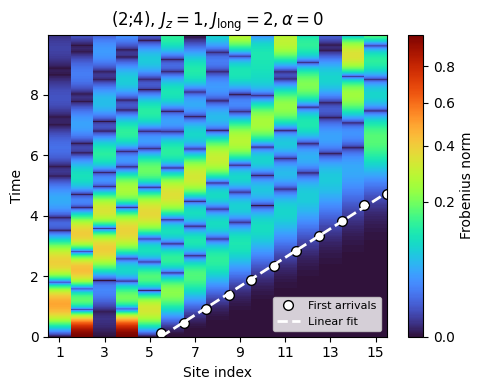

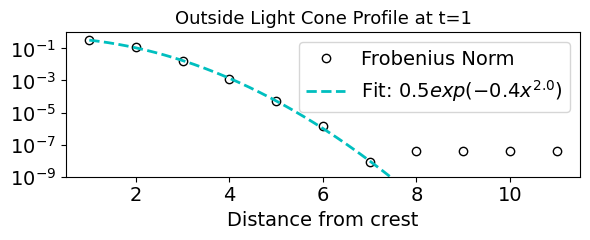

profile [3.16732585e-01 1.23405232e-01 1.65753346e-02 1.15369801e-03
 4.94519976e-05 1.40522121e-06 8.27840019e-09 3.83553855e-08
 3.88405974e-08 3.88466148e-08 3.88468147e-08]


In [22]:
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def load_mathematica_data(filename):
    """
    Load data from a Mathematica-style text file:
    {0.001707401450201651 + 0.*I, 5.646194622954682*^-9 + 0.*I, ...}
    Returns: 2D numpy array (rows = lines, cols = entries per line)
    """
    data = []
    with open(filename, "r") as f:
        for line in f:
            # Normalize Mathematica scientific notation: *^ -> e
            line = line.replace("*^", "e")

            # Remove curly braces
            line = line.strip().lstrip("{").rstrip("}")
            
            # Split by comma
            entries = line.split(",")
            
            # Extract real part (ignore imaginary part)
            row = []
            for e in entries:
                e = e.strip()
                # Remove the "+ 0.*I" if present
                e = e.split("+")[0].strip()
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)


# -----------------------------
# Example usage
# -----------------------------

# Define path to the data file
data_path = os.path.join("src", "N15B0LFIMHeffJlong2b1lc.txt")

# Load data from file; first column = time, rest = spatial density over time
raw_data = load_mathematica_data(data_path)


print("Shape:", raw_data.shape)
print(raw_data[-3])  # print first two rows


# Example: dummy first arrival points
# === First arrival points (site, time) ===
arrivals = [
    (5, 0.11),
    (6, 0.47),
    (7, 0.91),
    (8, 1.38),
    (9, 1.86),
    (10, 2.35),
    (11, 2.84),
    (12, 3.34),
    (13, 3.84),
    (14, 4.37),
    (15, 4.72)
]




x_points = np.array([a[0] for a in arrivals])   # site indices
y_points = np.array([a[1] for a in arrivals])   # times

# === Linear fit ===
fit_params = np.polyfit(x_points, y_points, 1)
fit_fn = np.poly1d(fit_params)
x_fit = np.linspace(x_points.min(), x_points.max(), 200)
y_fit = fit_fn(x_fit)

slope, intercept = fit_params

# === Simulation step size ===
step_size = 0.01   # <-- input your step size here
steps_per_unit = 1 / step_size
n_steps = raw_data.shape[0]

# Time array (row index → physical time)
time_axis = np.arange(n_steps) / steps_per_unit
t_min, t_max = time_axis.min(), time_axis.max()

# === Heatmap ===
plt.figure(figsize=(5, 4))

im = plt.imshow(
    raw_data,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    interpolation="none",
    norm=mcolors.PowerNorm(gamma=0.5, vmin=0, vmax=raw_data.max()),
    extent=[0, raw_data.shape[1], t_min, t_max+0.001]  # <-- keep full extent
)

# Overlay first arrival points
plt.plot(x_points, y_points, 'wo', markersize=7,
         markeredgecolor="k", label="First arrivals")

# Overlay best-fit line
plt.plot(x_fit, y_fit, 'w--', linewidth=2, label="Linear fit")

# Labels
plt.colorbar(im, label="Frobenius norm")
plt.xlabel("Site index")
plt.ylabel("Time")
plt.title(r"(2;4), $J_z=1, J_{\mathrm{long}}=2, \alpha=0$")

# Fix site index ticks at centers
n_sites = raw_data.shape[1]
step = 2  # show every 2nd site index
positions = np.arange(0.5, n_sites, step)
labels = np.arange(1, n_sites + 1, step)

plt.xticks(positions, labels)


plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.savefig("plt/N15B0LFIMHeffJlong2b1lc.svg", bbox_inches="tight") 
plt.show()

import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# === Pick time slice ===
time = 1  # physical time
t_index = int(time * steps_per_unit)
profile = raw_data[t_index, 4:]
sites = np.arange(1, profile.size+1)

# === Use first few points outside cone for fit ===
n_fit = 7   # number of points to use
x_fit_points = sites[:n_fit]
y_fit_points = profile[:n_fit]

# Avoid log of zero
mask = y_fit_points > 1e-14
x_fit_points = x_fit_points[mask]
y_fit_points = y_fit_points[mask]

# Model: log(y) = log(A) - a * x^p
def log_model(x, logA, a, p):
    return logA - a * (x**p)

# Fit in log space
logy = np.log(y_fit_points)
popt, _ = curve_fit(log_model, x_fit_points, logy,
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Reconstruct fitted curve
x_dense = np.linspace(sites.min(), sites.max(), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense**p_fit)

# === Plot semi-log (flattened aspect, bigger fonts) ===
plt.figure(figsize=(6, 2.5))  # flattened aspect
plt.semilogy(sites, profile, 'wo', markersize=6,
             markeredgecolor="k", label="Frobenius Norm")
plt.semilogy(x_dense, y_dense, 'c--', linewidth=2,
             label=fr"Fit: ${A_fit:.1f}exp({{-{a_fit:.1f} x^{{{p_fit:.1f}}}}})$")

plt.xlabel("Distance from crest", fontsize=14)
# plt.ylabel("Frobenius Norm", fontsize=12)
plt.title(f"Outside Light Cone Profile at t={time}", fontsize=13)
plt.ylim(1e-9, 1)   # y-axis range
plt.legend(fontsize=14, loc="upper right")

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig("plt/N15B0LFIMHeffJlong2b1lcOutLC.svg", bbox_inches="tight") 
plt.show()

print("profile",profile)

Shape: (10000, 15)
[0.00151441 0.01041284 0.00989249 0.03629725 0.00886489 0.1368075
 0.00128016 0.0858718  0.30342873 0.01725701 0.26103697 0.0979593
 0.01276057 0.04302939 0.20072576]


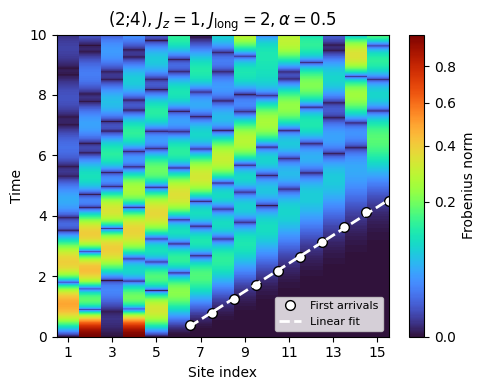

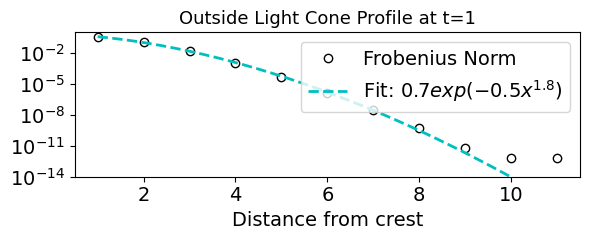

profile [3.16764717e-01 1.23455283e-01 1.65856311e-02 1.15465297e-03
 4.95372710e-05 1.44558521e-06 3.06023873e-08 4.91184871e-10
 5.59552404e-12 5.99520433e-13 5.99520433e-13]


In [24]:
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def load_mathematica_data(filename):
    """
    Load data from a Mathematica-style text file:
    {0.001707401450201651 + 0.*I, 5.646194622954682*^-9 + 0.*I, ...}
    Returns: 2D numpy array (rows = lines, cols = entries per line)
    """
    data = []
    with open(filename, "r") as f:
        for line in f:
            # Normalize Mathematica scientific notation: *^ -> e
            line = line.replace("*^", "e")

            # Remove curly braces
            line = line.strip().lstrip("{").rstrip("}")
            
            # Split by comma
            entries = line.split(",")
            
            # Extract real part (ignore imaginary part)
            row = []
            for e in entries:
                e = e.strip()
                # Remove the "+ 0.*I" if present
                e = e.split("+")[0].strip()
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)


# -----------------------------
# Example usage
# -----------------------------

# Define path to the data file
data_path = os.path.join("src", "N15B0LFIMHeffa05Jlong2b1lc.txt")

# Load data from file; first column = time, rest = spatial density over time
raw_data = load_mathematica_data(data_path)


print("Shape:", raw_data.shape)
print(raw_data[-3])  # print first two rows


# Example: dummy first arrival points
# === First arrival points (site, time) ===
arrivals = [
    (6, 0.39),
    (7, 0.80),
    (8, 1.24),
    (9, 1.70),
    (10, 2.17),
    (11, 2.65),
    (12, 3.13),
    (13, 3.62),
    (14, 4.12),
    (15, 4.49)
]




x_points = np.array([a[0] for a in arrivals])   # site indices
y_points = np.array([a[1] for a in arrivals])   # times

# === Linear fit ===
fit_params = np.polyfit(x_points, y_points, 1)
fit_fn = np.poly1d(fit_params)
x_fit = np.linspace(x_points.min(), x_points.max(), 200)
y_fit = fit_fn(x_fit)

slope, intercept = fit_params

# === Simulation step size ===
step_size = 0.001   # <-- input your step size here
steps_per_unit = 1 / step_size
n_steps = raw_data.shape[0]

# Time array (row index → physical time)
time_axis = np.arange(n_steps) / steps_per_unit
t_min, t_max = time_axis.min(), time_axis.max()

# === Heatmap ===
plt.figure(figsize=(5, 4))

im = plt.imshow(
    raw_data,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    interpolation="none",
    norm=mcolors.PowerNorm(gamma=0.5, vmin=0, vmax=raw_data.max()),
    extent=[0, raw_data.shape[1], t_min, t_max+0.001]  # <-- keep full extent
)

# Overlay first arrival points
plt.plot(x_points, y_points, 'wo', markersize=7,
         markeredgecolor="k", label="First arrivals")

# Overlay best-fit line
plt.plot(x_fit, y_fit, 'w--', linewidth=2, label="Linear fit")

# Labels
plt.colorbar(im, label="Frobenius norm")
plt.xlabel("Site index")
plt.ylabel("Time")
plt.title(r"(2;4), $J_z=1, J_{\mathrm{long}}=2, \alpha=0.5$")

# Fix site index ticks at centers
n_sites = raw_data.shape[1]
step = 2  # show every 2nd site index
positions = np.arange(0.5, n_sites, step)
labels = np.arange(1, n_sites + 1, step)

plt.xticks(positions, labels)


plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.savefig("plt/N15B0LFIMHeffa05Jlong2b1lc.svg", bbox_inches="tight") 
plt.show()

import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# === Pick time slice ===
time = 1  # physical time
t_index = int(time * steps_per_unit)
profile = raw_data[t_index, 4:]
sites = np.arange(1, profile.size+1)

# === Use first few points outside cone for fit ===
n_fit = 7   # number of points to use
x_fit_points = sites[:n_fit]
y_fit_points = profile[:n_fit]

# Avoid log of zero
mask = y_fit_points > 1e-14
x_fit_points = x_fit_points[mask]
y_fit_points = y_fit_points[mask]

# Model: log(y) = log(A) - a * x^p
def log_model(x, logA, a, p):
    return logA - a * (x**p)

# Fit in log space
logy = np.log(y_fit_points)
popt, _ = curve_fit(log_model, x_fit_points, logy,
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Reconstruct fitted curve
x_dense = np.linspace(sites.min(), sites.max(), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense**p_fit)

# === Plot semi-log (flattened aspect, bigger fonts) ===
plt.figure(figsize=(6, 2.5))  # flattened aspect
plt.semilogy(sites, profile, 'wo', markersize=6,
             markeredgecolor="k", label="Frobenius Norm")
plt.semilogy(x_dense, y_dense, 'c--', linewidth=2,
             label=fr"Fit: ${A_fit:.1f}exp({{-{a_fit:.1f} x^{{{p_fit:.1f}}}}})$")

plt.xlabel("Distance from crest", fontsize=14)
# plt.ylabel("Frobenius Norm", fontsize=12)
plt.title(f"Outside Light Cone Profile at t={time}", fontsize=13)
plt.ylim(1e-14, 1)   # y-axis range
plt.legend(fontsize=14, loc="upper right")

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig("plt/N15B0LFIMHeffa05Jlong2b1lcOutLC.svg", bbox_inches="tight") 
plt.show()

print("profile",profile)

Shape: (10000, 15)
[0.09577823 0.06171814 0.01514605 0.03219733 0.00533417 0.00289222
 0.05337933 0.05005534 0.02234711 0.04114987 0.22296267 0.15767098
 0.08924945 0.0262523  0.00262334]


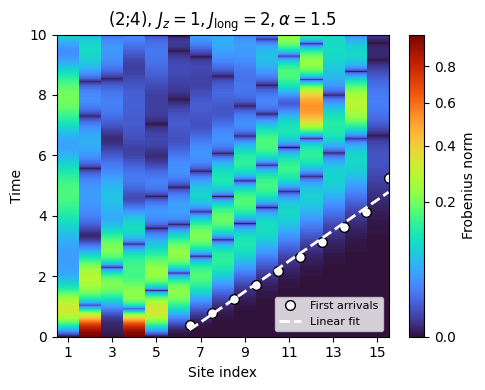

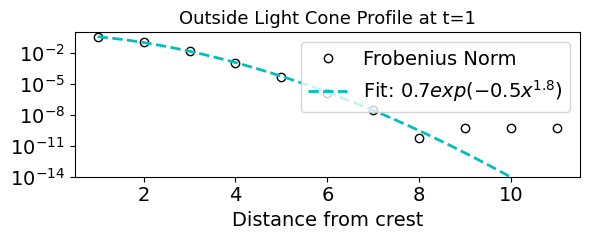

profile [3.17956513e-01 1.23126335e-01 1.65168107e-02 1.14993941e-03
 4.93669186e-05 1.44117840e-06 2.99839931e-08 6.07958128e-11
 5.45186118e-10 5.51203527e-10 5.51403367e-10]


In [25]:
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def load_mathematica_data(filename):
    """
    Load data from a Mathematica-style text file:
    {0.001707401450201651 + 0.*I, 5.646194622954682*^-9 + 0.*I, ...}
    Returns: 2D numpy array (rows = lines, cols = entries per line)
    """
    data = []
    with open(filename, "r") as f:
        for line in f:
            # Normalize Mathematica scientific notation: *^ -> e
            line = line.replace("*^", "e")

            # Remove curly braces
            line = line.strip().lstrip("{").rstrip("}")
            
            # Split by comma
            entries = line.split(",")
            
            # Extract real part (ignore imaginary part)
            row = []
            for e in entries:
                e = e.strip()
                # Remove the "+ 0.*I" if present
                e = e.split("+")[0].strip()
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)


# -----------------------------
# Example usage
# -----------------------------

# Define path to the data file
data_path = os.path.join("src", "N15B0LFIMHeffa15Jlong2b1lc.txt")

# Load data from file; first column = time, rest = spatial density over time
raw_data = load_mathematica_data(data_path)


print("Shape:", raw_data.shape)
print(raw_data[-3])  # print first two rows


# Example: dummy first arrival points
# === First arrival points (site, time) ===
arrivals = [
    (6, 0.39),
    (7, 0.80),
    (8, 1.24),
    (9, 1.70),
    (10, 2.17),
    (11, 2.65),
    (12, 3.13),
    (13, 3.62),
    (14, 4.12),
    (15, 5.24)
]





x_points = np.array([a[0] for a in arrivals])   # site indices
y_points = np.array([a[1] for a in arrivals])   # times

# === Linear fit ===
fit_params = np.polyfit(x_points, y_points, 1)
fit_fn = np.poly1d(fit_params)
x_fit = np.linspace(x_points.min(), x_points.max(), 200)
y_fit = fit_fn(x_fit)

slope, intercept = fit_params

# === Simulation step size ===
step_size = 0.001   # <-- input your step size here
steps_per_unit = 1 / step_size
n_steps = raw_data.shape[0]

# Time array (row index → physical time)
time_axis = np.arange(n_steps) / steps_per_unit
t_min, t_max = time_axis.min(), time_axis.max()

# === Heatmap ===
plt.figure(figsize=(5, 4))

im = plt.imshow(
    raw_data,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    interpolation="none",
    norm=mcolors.PowerNorm(gamma=0.5, vmin=0, vmax=raw_data.max()),
    extent=[0, raw_data.shape[1], t_min, t_max+0.001]  # <-- keep full extent
)

# Overlay first arrival points
plt.plot(x_points, y_points, 'wo', markersize=7,
         markeredgecolor="k", label="First arrivals")

# Overlay best-fit line
plt.plot(x_fit, y_fit, 'w--', linewidth=2, label="Linear fit")

# Labels
plt.colorbar(im, label="Frobenius norm")
plt.xlabel("Site index")
plt.ylabel("Time")
plt.title(r"(2;4), $J_z=1, J_{\mathrm{long}}=2, \alpha=1.5$")

# Fix site index ticks at centers
n_sites = raw_data.shape[1]
step = 2  # show every 2nd site index
positions = np.arange(0.5, n_sites, step)
labels = np.arange(1, n_sites + 1, step)

plt.xticks(positions, labels)


plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.savefig("plt/N15B0LFIMHeffa15Jlong2b1lc.svg", bbox_inches="tight") 
plt.show()

import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# === Pick time slice ===
time = 1  # physical time
t_index = int(time * steps_per_unit)
profile = raw_data[t_index, 4:]
sites = np.arange(1, profile.size+1)

# === Use first few points outside cone for fit ===
n_fit = 7   # number of points to use
x_fit_points = sites[:n_fit]
y_fit_points = profile[:n_fit]

# Avoid log of zero
mask = y_fit_points > 1e-14
x_fit_points = x_fit_points[mask]
y_fit_points = y_fit_points[mask]

# Model: log(y) = log(A) - a * x^p
def log_model(x, logA, a, p):
    return logA - a * (x**p)

# Fit in log space
logy = np.log(y_fit_points)
popt, _ = curve_fit(log_model, x_fit_points, logy,
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Reconstruct fitted curve
x_dense = np.linspace(sites.min(), sites.max(), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense**p_fit)

# === Plot semi-log (flattened aspect, bigger fonts) ===
plt.figure(figsize=(6, 2.5))  # flattened aspect
plt.semilogy(sites, profile, 'wo', markersize=6,
             markeredgecolor="k", label="Frobenius Norm")
plt.semilogy(x_dense, y_dense, 'c--', linewidth=2,
             label=fr"Fit: ${A_fit:.1f}exp({{-{a_fit:.1f} x^{{{p_fit:.1f}}}}})$")

plt.xlabel("Distance from crest", fontsize=14)
# plt.ylabel("Frobenius Norm", fontsize=12)
plt.title(f"Outside Light Cone Profile at t={time}", fontsize=13)
plt.ylim(1e-14, 1)   # y-axis range
plt.legend(fontsize=14, loc="upper right")

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig("plt/N15B0LFIMHeffa15Jlong2b1lcOutLC.svg", bbox_inches="tight") 
plt.show()

print("profile",profile)

Shape: (20000, 50)
[0.00129931 0.00282057 0.01061643 0.00856874 0.02141037 0.00508313
 0.01343194 0.02842623 0.03038736 0.08528259 0.0695125  0.08275081
 0.00646815 0.03844893 0.10979293 0.09396702 0.0323979  0.05802418
 0.10937251 0.0458831  0.0304681  0.10297467 0.01849998 0.0497148
 0.07741869 0.04072837 0.07643861 0.02873805 0.08373615 0.04674009
 0.08726657 0.10900593 0.02441816 0.15891974 0.16947781 0.08341363
 0.00402449 0.04338253 0.04603166 0.03883948 0.03395953 0.03037995
 0.0251056  0.01822313 0.01144139 0.00637703 0.00302727 0.00144657
 0.0004326  0.00033697]


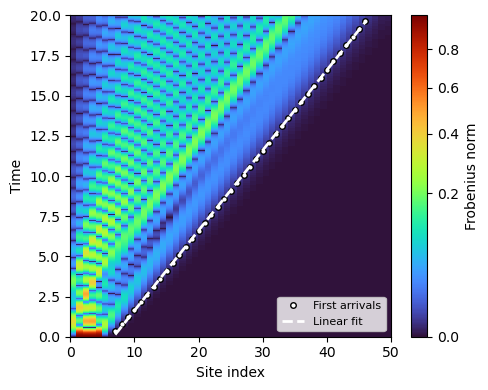

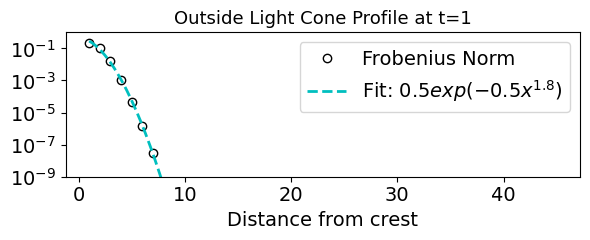

profile [2.23588626e-01 1.08968829e-01 1.55182714e-02 1.10752721e-03
 4.81384856e-05 1.41544261e-06 2.99089864e-08 2.76600964e-10
 2.02993178e-10 2.09210427e-10 2.09010587e-10 2.09210427e-10
 2.09210427e-10 2.09210427e-10 2.09210427e-10 2.09210427e-10
 2.09210427e-10 2.09210427e-10 2.09210427e-10 2.09210427e-10
 2.09210427e-10 2.09210427e-10 2.09210427e-10 2.09210427e-10
 2.09210427e-10 2.09210427e-10 2.09210427e-10 2.09210427e-10
 2.09210427e-10 2.09210427e-10 2.09210427e-10 2.09210427e-10
 2.09210427e-10 2.09210427e-10 2.09210427e-10 2.09210427e-10
 2.09210427e-10 2.09210427e-10 2.09210427e-10 2.09210427e-10
 2.09210427e-10 2.09210427e-10 2.09210427e-10 2.09210427e-10
 2.09210427e-10]


In [15]:
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def load_mathematica_data(filename):
    """
    Load data from a Mathematica-style text file:
    {0.001707401450201651 + 0.*I, 5.646194622954682*^-9 + 0.*I, ...}
    Returns: 2D numpy array (rows = lines, cols = entries per line)
    """
    data = []
    with open(filename, "r") as f:
        for line in f:
            # Normalize Mathematica scientific notation: *^ -> e
            line = line.replace("*^", "e")

            # Remove curly braces
            line = line.strip().lstrip("{").rstrip("}")
            
            # Split by comma
            entries = line.split(",")
            
            # Extract real part (ignore imaginary part)
            row = []
            for e in entries:
                e = e.strip()
                # Remove the "+ 0.*I" if present
                e = e.split("+")[0].strip()
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)


# -----------------------------
# Example usage
# -----------------------------

# Define path to the data file
data_path = os.path.join("src", "N50B0LFIMHeffb2lc.txt")

# Load data from file; first column = time, rest = spatial density over time
raw_data = load_mathematica_data(data_path)


print("Shape:", raw_data.shape)
print(raw_data[-3])  # print first two rows


# Example: dummy first arrival points
# === First arrival points (site, time) ===
arrivals = [
    (7, 0.37), (8, 0.77), (9, 1.21), (10, 1.67),
    (11, 2.14), (12, 2.62), (13, 3.10), (14, 3.59), (15, 4.08),
    (16, 4.58), (17, 5.07), (18, 5.57), (19, 6.07), (20, 6.57),
    (21, 7.07), (22, 7.57), (23, 8.07), (24, 8.57), (25, 9.07),
    (26, 9.58), (27, 10.08), (28, 10.58), (29, 11.09), (30, 11.59),
    (31, 12.09), (32, 12.60), (33, 13.10), (34, 13.61), (35, 14.11),
    (36, 14.62), (37, 15.12), (38, 15.63), (39, 16.13), (40, 16.63),
    (41, 17.14), (42, 17.64), (43, 18.15), (44, 18.65), (45, 19.16),
    (46, 19.66)
]


x_points = np.array([a[0] for a in arrivals])   # site indices
y_points = np.array([a[1] for a in arrivals])   # times

# === Linear fit ===
fit_params = np.polyfit(x_points, y_points, 1)
fit_fn = np.poly1d(fit_params)
x_fit = np.linspace(x_points.min(), x_points.max(), 200)
y_fit = fit_fn(x_fit)

slope, intercept = fit_params

# === Simulation step size ===
step_size = 0.001   # <-- input your step size here
steps_per_unit = 1 / step_size
n_steps = raw_data.shape[0]

# Time array (row index → physical time)
time_axis = np.arange(n_steps) / steps_per_unit
t_min, t_max = time_axis.min(), time_axis.max()

# === Heatmap ===
plt.figure(figsize=(5, 4))

im = plt.imshow(
    raw_data,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    interpolation="none",
    norm=mcolors.PowerNorm(gamma=0.5, vmin=0, vmax=raw_data.max()),
    extent=[0, raw_data.shape[1], t_min, t_max+0.001]  # <-- keep full extent
)

# Overlay first arrival points
plt.plot(x_points, y_points, 'wo', markersize=4, 
         markeredgecolor="k", label="First arrivals")

# Overlay best-fit line
plt.plot(x_fit, y_fit, 'w--', linewidth=2, label="Linear fit")

# Labels
plt.colorbar(im, label="Frobenius norm")
plt.xlabel("Site index")
plt.ylabel("Time")
# plt.title(r"(2;4), $J_z=1, J_{\mathrm{long}}=2, \alpha=1.5$")

# Fix site index ticks at centers
n_sites = raw_data.shape[1]
step = 10  # spacing between ticks

positions = np.arange(0, n_sites+1, step)     # positions on the axis
labels = np.arange(0, n_sites+1, step)      # human-readable labels


plt.xticks(positions, labels)


plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.savefig("plt/N50B0LFIMHeffb2lc.svg", bbox_inches="tight") 
plt.show()

import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# === Pick time slice ===
time = 1  # physical time
t_index = int(time * steps_per_unit)
profile = raw_data[t_index, 5:]
sites = np.arange(1, profile.size+1)

# === Use first few points outside cone for fit ===
n_fit = 8   # number of points to use
x_fit_points = sites[:n_fit]
y_fit_points = profile[:n_fit]

# Avoid log of zero
mask = y_fit_points > 1e-14
x_fit_points = x_fit_points[mask]
y_fit_points = y_fit_points[mask]

# Model: log(y) = log(A) - a * x^p
def log_model(x, logA, a, p):
    return logA - a * (x**p)

# Fit in log space
logy = np.log(y_fit_points)
popt, _ = curve_fit(log_model, x_fit_points, logy,
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Reconstruct fitted curve
x_dense = np.linspace(sites.min(), sites.max(), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense**p_fit)

# === Plot semi-log (flattened aspect, bigger fonts) ===
plt.figure(figsize=(6, 2.5))  # flattened aspect
plt.semilogy(sites, profile, 'wo', markersize=6,
             markeredgecolor="k", label="Frobenius Norm")
plt.semilogy(x_dense, y_dense, 'c--', linewidth=2,
             label=fr"Fit: ${A_fit:.1f}exp({{-{a_fit:.1f} x^{{{p_fit:.1f}}}}})$")

plt.xlabel("Distance from crest", fontsize=14)
# plt.ylabel("Frobenius Norm", fontsize=12)
plt.title(f"Outside Light Cone Profile at t={time}", fontsize=13)
plt.ylim(1e-9, 1)   # y-axis range
plt.legend(fontsize=14, loc="upper right")

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig("plt/N50B0LFIMHeffb2lcOutLC.svg", bbox_inches="tight") 
plt.show()

print("profile",profile)

Shape: (10000, 30)
[1.30370413e-01 1.10046523e-01 1.04404785e-02 2.56181514e-02
 2.24975552e-02 1.48653988e-02 1.20945125e-02 1.43392015e-02
 1.49919162e-02 2.02948515e-02 3.27831740e-02 2.37596523e-02
 1.56822293e-02 6.86436541e-02 1.26059547e-01 8.06969180e-02
 3.75062189e-02 1.08788675e-01 8.90893369e-02 3.21883202e-02
 6.58933469e-03 1.70025370e-02 1.27761307e-02 6.48250913e-03
 2.53745050e-03 7.38438988e-04 5.46797854e-05 1.33159556e-04
 2.93167324e-05 8.28873424e-05]


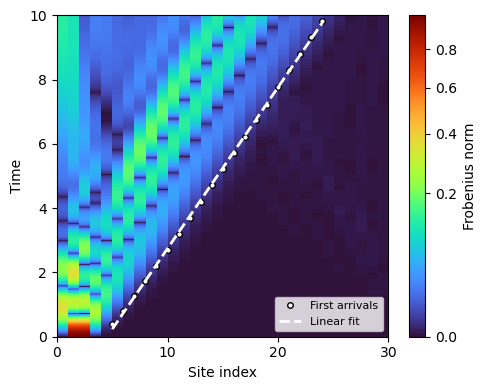

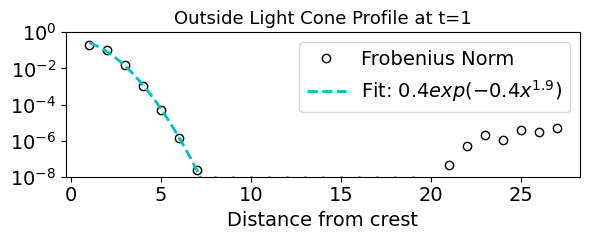

profile [2.10930689e-01 1.07565214e-01 1.53546804e-02 1.09533228e-03
 4.75783602e-05 1.39292040e-06 2.36453968e-08 5.64082114e-09
 6.11519724e-09 6.12119244e-09 6.12121465e-09 6.12121465e-09
 6.12121465e-09 6.12121465e-09 6.12119244e-09 6.12119244e-09
 6.12121465e-09 6.11899420e-09 6.03141981e-09 3.52240459e-09
 4.23522106e-08 4.96215402e-07 2.01854040e-06 1.10524201e-06
 3.84499479e-06 2.97849718e-06 5.33220781e-06]


In [3]:
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def load_mathematica_data(filename):
    """
    Load data from a Mathematica-style text file:
    {0.001707401450201651 + 0.*I, 5.646194622954682*^-9 + 0.*I, ...}
    Returns: 2D numpy array (rows = lines, cols = entries per line)
    """
    data = []
    with open(filename, "r") as f:
        for line in f:
            # Normalize Mathematica scientific notation: *^ -> e
            line = line.replace("*^", "e")

            # Remove curly braces
            line = line.strip().lstrip("{").rstrip("}")
            
            # Split by comma
            entries = line.split(",")
            
            # Extract real part (ignore imaginary part)
            row = []
            for e in entries:
                e = e.strip()
                # Remove the "+ 0.*I" if present
                e = e.split("+")[0].strip()
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)


# -----------------------------
# Example usage
# -----------------------------

# Define path to the data file
data_path = os.path.join("src", "N30B0LFIMHeffb2lcalpha05far.txt")

# Load data from file; first column = time, rest = spatial density over time
raw_data = load_mathematica_data(data_path)


print("Shape:", raw_data.shape)
print(raw_data[-3])  # print first two rows


# Example: dummy first arrival points
# === First arrival points (site, time) ===
arrivals = [
    (5, 0.39), (6, 0.80), (7, 1.26), (8, 1.73), (9, 2.21),
    (10, 2.70), (11, 3.20), (12, 3.70), (13, 4.20), (14, 4.71),
    (15, 5.22), (16, 5.72), (17, 6.23), (18, 6.76), (19, 7.20),
    (20, 7.76), (21, 8.30), (22, 8.81), (23, 9.32), (24, 9.84)
]


x_points = np.array([a[0] for a in arrivals])   # site indices
y_points = np.array([a[1] for a in arrivals])   # times

# === Linear fit ===
fit_params = np.polyfit(x_points, y_points, 1)
fit_fn = np.poly1d(fit_params)
x_fit = np.linspace(x_points.min(), x_points.max(), 200)
y_fit = fit_fn(x_fit)

slope, intercept = fit_params

# === Simulation step size ===
step_size = 0.001   # <-- input your step size here
steps_per_unit = 1 / step_size
n_steps = raw_data.shape[0]

# Time array (row index → physical time)
time_axis = np.arange(n_steps) / steps_per_unit
t_min, t_max = time_axis.min(), time_axis.max()

# === Heatmap ===
plt.figure(figsize=(5, 4))

im = plt.imshow(
    raw_data,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    interpolation="none",
    norm=mcolors.PowerNorm(gamma=0.5, vmin=0, vmax=raw_data.max()),
    extent=[0, raw_data.shape[1], t_min, t_max+0.001]  # <-- keep full extent
)

# Overlay first arrival points
plt.plot(x_points, y_points, 'wo', markersize=4, 
         markeredgecolor="k", label="First arrivals")

# Overlay best-fit line
plt.plot(x_fit, y_fit, 'w--', linewidth=2, label="Linear fit")

# Labels
plt.colorbar(im, label="Frobenius norm")
plt.xlabel("Site index")
plt.ylabel("Time")
# plt.title(r"(2;4), $J_z=1, J_{\mathrm{long}}=2, \alpha=1.5$")

# Fix site index ticks at centers
n_sites = raw_data.shape[1]
step = 10  # spacing between ticks

positions = np.arange(0, n_sites+1, step)     # positions on the axis
labels = np.arange(0, n_sites+1, step)      # human-readable labels


plt.xticks(positions, labels)


plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.savefig("plt/N30B0LFIMHeffb2lcalpha05far.svg", bbox_inches="tight") 
plt.show()

import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# === Pick time slice ===
time = 1  # physical time
t_index = int(time * steps_per_unit)
profile = raw_data[t_index, 3:]
sites = np.arange(1, profile.size+1)

# === Use first few points outside cone for fit ===
n_fit = 7   # number of points to use
x_fit_points = sites[:n_fit]
y_fit_points = profile[:n_fit]

# Avoid log of zero
mask = y_fit_points > 1e-14
x_fit_points = x_fit_points[mask]
y_fit_points = y_fit_points[mask]

# Model: log(y) = log(A) - a * x^p
def log_model(x, logA, a, p):
    return logA - a * (x**p)

# Fit in log space
logy = np.log(y_fit_points)
popt, _ = curve_fit(log_model, x_fit_points, logy,
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Reconstruct fitted curve
x_dense = np.linspace(sites.min(), sites.max(), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense**p_fit)

# === Plot semi-log (flattened aspect, bigger fonts) ===
plt.figure(figsize=(6, 2.5))  # flattened aspect
plt.semilogy(sites, profile, 'wo', markersize=6,
             markeredgecolor="k", label="Frobenius Norm")
plt.semilogy(x_dense, y_dense, 'c--', linewidth=2,
             label=fr"Fit: ${A_fit:.1f}exp({{-{a_fit:.1f} x^{{{p_fit:.1f}}}}})$")

plt.xlabel("Distance from crest", fontsize=14)
# plt.ylabel("Frobenius Norm", fontsize=12)
plt.title(f"Outside Light Cone Profile at t={time}", fontsize=13)
plt.ylim(1e-8, 1)   # y-axis range
plt.legend(fontsize=14, loc="upper right")

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig("plt/N30B0LFIMHeffb2lcalpha05farOutLC.svg", bbox_inches="tight") 
plt.show()

print("profile",profile)

Shape: (10000, 30)
[2.51936063e-03 3.20943304e-03 4.42876550e-02 4.91647719e-02
 1.67645452e-01 1.46679004e-01 1.57902640e-01 8.73621130e-03
 1.51425056e-01 1.64090248e-01 9.08622702e-02 1.37319223e-01
 1.29082622e-01 1.28351326e-01 7.89657824e-02 2.09248087e-01
 1.41865221e-01 4.54786745e-03 4.47495830e-02 2.37359638e-02
 1.33474314e-02 2.60513352e-02 3.49514028e-02 2.97006282e-02
 1.81747560e-02 8.67059391e-03 3.35442056e-03 1.12170035e-03
 2.83856963e-04 1.10658496e-04]


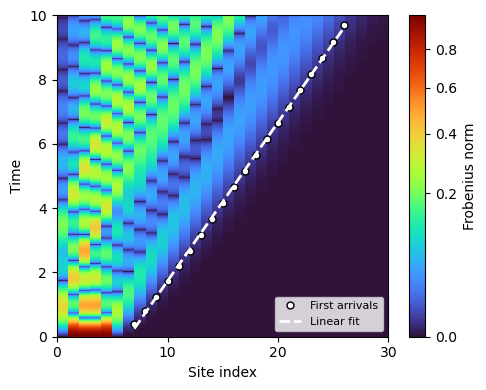

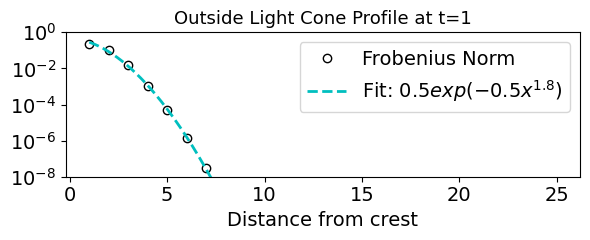

profile [2.23588972e-01 1.08969834e-01 1.55184916e-02 1.10754794e-03
 4.81397696e-05 1.41567360e-06 3.01032088e-08 4.70001815e-10
 9.59232693e-12 1.56097357e-11 1.58095759e-11 1.56097357e-11
 1.56097357e-11 1.56097357e-11 1.56097357e-11 1.56097357e-11
 1.56097357e-11 1.56097357e-11 1.56097357e-11 1.56097357e-11
 1.56097357e-11 1.56097357e-11 1.56097357e-11 1.56097357e-11
 1.56097357e-11]


In [10]:
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def load_mathematica_data(filename):
    """
    Load data from a Mathematica-style text file:
    {0.001707401450201651 + 0.*I, 5.646194622954682*^-9 + 0.*I, ...}
    Returns: 2D numpy array (rows = lines, cols = entries per line)
    """
    data = []
    with open(filename, "r") as f:
        for line in f:
            # Normalize Mathematica scientific notation: *^ -> e
            line = line.replace("*^", "e")

            # Remove curly braces
            line = line.strip().lstrip("{").rstrip("}")
            
            # Split by comma
            entries = line.split(",")
            
            # Extract real part (ignore imaginary part)
            row = []
            for e in entries:
                e = e.strip()
                # Remove the "+ 0.*I" if present
                e = e.split("+")[0].strip()
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)


# -----------------------------
# Example usage
# -----------------------------

# Define path to the data file
data_path = os.path.join("src", "N30B0LFIMHeffb2lcalpha05close.txt")

# Load data from file; first column = time, rest = spatial density over time
raw_data = load_mathematica_data(data_path)


print("Shape:", raw_data.shape)
print(raw_data[-3])  # print first two rows


# Example: dummy first arrival points
# === First arrival points (site, time) ===
arrivals = [ (7, 0.39), (8, 0.8), (9, 1.25),
    (10, 1.72), (11, 2.2), (12, 2.68), (13, 3.17), (14, 3.66),
    (15, 4.16), (16, 4.66), (17, 5.16), (18, 5.66), (19, 6.16),
    (20, 6.66), (21, 7.16), (22, 7.67), (23, 8.17), (24, 8.68),
    (25, 9.18), (26, 9.69)
]


x_points = np.array([a[0] for a in arrivals])   # site indices
y_points = np.array([a[1] for a in arrivals])   # times

# === Linear fit ===
fit_params = np.polyfit(x_points, y_points, 1)
fit_fn = np.poly1d(fit_params)
x_fit = np.linspace(x_points.min(), x_points.max(), 200)
y_fit = fit_fn(x_fit)

slope, intercept = fit_params

# === Simulation step size ===
step_size = 0.001   # <-- input your step size here
steps_per_unit = 1 / step_size
n_steps = raw_data.shape[0]

# Time array (row index → physical time)
time_axis = np.arange(n_steps) / steps_per_unit
t_min, t_max = time_axis.min(), time_axis.max()

# === Heatmap ===
plt.figure(figsize=(5, 4))

im = plt.imshow(
    raw_data,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    interpolation="none",
    norm=mcolors.PowerNorm(gamma=0.5, vmin=0, vmax=raw_data.max()),
    extent=[0, raw_data.shape[1], t_min, t_max+0.001]  # <-- keep full extent
)

# Overlay first arrival points
plt.plot(x_points, y_points, 'wo', markersize=5, 
         markeredgecolor="k", label="First arrivals")

# Overlay best-fit line
plt.plot(x_fit, y_fit, 'w--', linewidth=2, label="Linear fit")

# Labels
plt.colorbar(im, label="Frobenius norm")
plt.xlabel("Site index")
plt.ylabel("Time")
# plt.title(r"(2;4), $J_z=1, J_{\mathrm{long}}=2, \alpha=1.5$")

# Fix site index ticks at centers
n_sites = raw_data.shape[1]
step = 10  # spacing between ticks

positions = np.arange(0, n_sites+1, step)     # positions on the axis
labels = np.arange(0, n_sites+1, step)      # human-readable labels


plt.xticks(positions, labels)


plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.savefig("plt/N30B0LFIMHeffb2lcalpha05close.svg", bbox_inches="tight") 
plt.show()

import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# === Pick time slice ===
time = 1  # physical time
t_index = int(time * steps_per_unit)
profile = raw_data[t_index, 5:]
sites = np.arange(1, profile.size+1)

# === Use first few points outside cone for fit ===
n_fit = 7   # number of points to use
x_fit_points = sites[:n_fit]
y_fit_points = profile[:n_fit]

# Avoid log of zero
mask = y_fit_points > 1e-14
x_fit_points = x_fit_points[mask]
y_fit_points = y_fit_points[mask]

# Model: log(y) = log(A) - a * x^p
def log_model(x, logA, a, p):
    return logA - a * (x**p)

# Fit in log space
logy = np.log(y_fit_points)
popt, _ = curve_fit(log_model, x_fit_points, logy,
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Reconstruct fitted curve
x_dense = np.linspace(sites.min(), sites.max(), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense**p_fit)

# === Plot semi-log (flattened aspect, bigger fonts) ===
plt.figure(figsize=(6, 2.5))  # flattened aspect
plt.semilogy(sites, profile, 'wo', markersize=6,
             markeredgecolor="k", label="Frobenius Norm")
plt.semilogy(x_dense, y_dense, 'c--', linewidth=2,
             label=fr"Fit: ${A_fit:.1f}exp({{-{a_fit:.1f} x^{{{p_fit:.1f}}}}})$")

plt.xlabel("Distance from crest", fontsize=14)
# plt.ylabel("Frobenius Norm", fontsize=12)
plt.title(f"Outside Light Cone Profile at t={time}", fontsize=13)
plt.ylim(1e-8, 1)   # y-axis range
plt.legend(fontsize=14, loc="upper right")

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig("plt/N30B0LFIMHeffb2lcalpha05closeOutLC.svg", bbox_inches="tight") 
plt.show()

print("profile",profile)

In [ ]:
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def load_mathematica_data(filename):
    """
    Load data from a Mathematica-style text file:
    {0.001707401450201651 + 0.*I, 5.646194622954682*^-9 + 0.*I, ...}
    Returns: 2D numpy array (rows = lines, cols = entries per line)
    """
    data = []
    with open(filename, "r") as f:
        for line in f:
            # Normalize Mathematica scientific notation: *^ -> e
            line = line.replace("*^", "e")

            # Remove curly braces
            line = line.strip().lstrip("{").rstrip("}")
            
            # Split by comma
            entries = line.split(",")
            
            # Extract real part (ignore imaginary part)
            row = []
            for e in entries:
                e = e.strip()
                # Remove the "+ 0.*I" if present
                e = e.split("+")[0].strip()
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)


# -----------------------------
# Example usage
# -----------------------------

# Define path to the data file
data_path = os.path.join("src", "N400B0LFIMHeffb2lcalpha05farPlot.txt")

# Load data from file; first column = time, rest = spatial density over time
raw_data = load_mathematica_data(data_path)


print("Shape:", raw_data.shape)
print(raw_data[-3])  # print first two rows


# Example: dummy first arrival points
# === First arrival points (site, time) ===
arrivals = [ (7, 0.39), (8, 0.8), (9, 1.25),
    (10, 1.72), (11, 2.2), (12, 2.68), (13, 3.17), (14, 3.66),
    (15, 4.16), (16, 4.66), (17, 5.16), (18, 5.66), (19, 6.16),
    (20, 6.66), (21, 7.16), (22, 7.67), (23, 8.17), (24, 8.68),
    (25, 9.18), (26, 9.69)
]


x_points = np.array([a[0] for a in arrivals])   # site indices
y_points = np.array([a[1] for a in arrivals])   # times

# === Linear fit ===
fit_params = np.polyfit(x_points, y_points, 1)
fit_fn = np.poly1d(fit_params)
x_fit = np.linspace(x_points.min(), x_points.max(), 200)
y_fit = fit_fn(x_fit)

slope, intercept = fit_params

# === Simulation step size ===
step_size = 0.001   # <-- input your step size here
steps_per_unit = 1 / step_size
n_steps = raw_data.shape[0]

# Time array (row index → physical time)
time_axis = np.arange(n_steps) / steps_per_unit
t_min, t_max = time_axis.min(), time_axis.max()

# === Heatmap ===
plt.figure(figsize=(5, 4))

im = plt.imshow(
    raw_data,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    interpolation="none",
    norm=mcolors.PowerNorm(gamma=0.5, vmin=0, vmax=raw_data.max()),
    extent=[0, raw_data.shape[1], t_min, t_max+0.001]  # <-- keep full extent
)

# Overlay first arrival points
plt.plot(x_points, y_points, 'wo', markersize=5, 
         markeredgecolor="k", label="First arrivals")

# Overlay best-fit line
plt.plot(x_fit, y_fit, 'w--', linewidth=2, label="Linear fit")

# Labels
plt.colorbar(im, label="Frobenius norm")
plt.xlabel("Site index")
plt.ylabel("Time")
# plt.title(r"(2;4), $J_z=1, J_{\mathrm{long}}=2, \alpha=1.5$")

# Fix site index ticks at centers
n_sites = raw_data.shape[1]
step = 10  # spacing between ticks

positions = np.arange(0, n_sites+1, step)     # positions on the axis
labels = np.arange(0, n_sites+1, step)      # human-readable labels


plt.xticks(positions, labels)


plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.savefig("plt/N30B0LFIMHeffb2lcalpha05close.svg", bbox_inches="tight") 
plt.show()

C:\Users\shrey\AppData\Local\Temp\ipykernel_20852\968262212.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\shrey\AppData\Local\Temp\ipykernel_20852\968262212.py:77: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


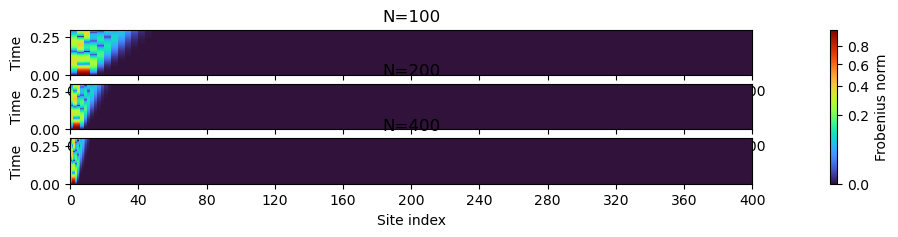

In [20]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def load_mathematica_data(filename):
    """Load Mathematica-style array from file into numpy array"""
    data = []
    with open(filename, "r") as f:
        for line in f:
            line = line.replace("*^", "e")  # scientific notation
            line = line.strip().lstrip("{").rstrip("}")
            entries = line.split(",")
            row = []
            for e in entries:
                e = e.strip()
                e = e.split("+")[0].strip()  # drop imaginary part
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)


def plot_lightcone(ax, raw_data, step_size=0.01, title=None):
    """Plot one dataset as a heatmap"""
    steps_per_unit = 1 / step_size
    n_steps = raw_data.shape[0]
    time_axis = np.arange(n_steps) / steps_per_unit
    t_min, t_max = time_axis.min(), time_axis.max()

    im = ax.imshow(
        raw_data,
        aspect="auto",
        origin="lower",
        cmap="turbo",
        interpolation="none",
        norm=mcolors.PowerNorm(gamma=0.5, vmin=0, vmax=raw_data.max()),
        extent=[0, raw_data.shape[1], t_min, t_max+0.001]
    )

    ax.set_xlabel("Site index")
    ax.set_ylabel("Time")
    if title:
        ax.set_title(title)

    # site index ticks
    n_sites = raw_data.shape[1]
    step = max(10, n_sites // 10)
    positions = np.arange(0, n_sites+1, step)
    labels = np.arange(0, n_sites+1, step)
    ax.set_xticks(positions, labels)

    return im


# -------------------------------------------
# Files and plotting
# -------------------------------------------

files = [
    ("src/N100B0LFIMHeffb2lcalpha05farPlot.txt", "N=100"),
    ("src/N200B0LFIMHeffb2lcalpha05far.txt", "N=200"),
    ("src/N400B0LFIMHeffb2lcalpha05farPlot.txt", "N=400"),
]

fig, axes = plt.subplots(3, 1, figsize=(10, 2), sharex=False)

for ax, (filename, title) in zip(axes, files):
    raw_data = load_mathematica_data(filename)
    im = plot_lightcone(ax, raw_data, step_size=0.001, title=title)

fig.colorbar(im, ax=axes, orientation="vertical", fraction=0.02, pad=0.1, label="Frobenius norm")

plt.tight_layout()
plt.savefig("plt/NVariedB0LFIMHeffb2lcalpha05far.svg", bbox_inches="tight")
plt.show()


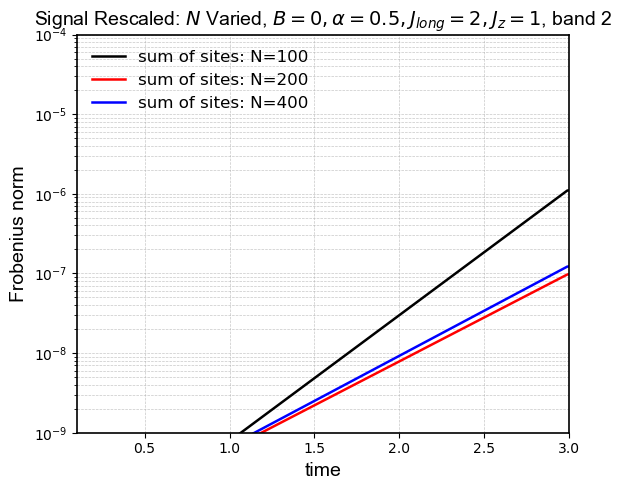

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# --- Convert Mathematica lists to numpy arrays ---
sitesum100Rescaled = np.array([
    [0.01, 0.], [0.02, 1.63203e-11], [0.03, 1.51879e-11], [0.04, 3.82584e-11],
    [0.05, 3.08201e-11], [0.06, 3.09759e-11], [0.07, 4.71633e-11],
    [0.08, 5.89548e-11], [0.09, 6.55606e-11], [0.1, 2.95795e-11],
    # ... keep filling the full array as you pasted ...
    [2.99, 1.09826e-6], [3.0, 1.10528e-6]
])

sitesum200Rescaled = np.array([
    [0.01, 0.], [0.02, 2.39808e-11], [0.03, 3.19744e-11], [0.04, 4.69624e-11],
    [0.05, 5.47562e-11], [0.06, 6.3749e-11], [0.07, 7.09434e-11],
    [0.08, 7.8937e-11], [0.09, 7.25644e-11], [0.1, 6.31498e-11],
    # ... continue filling ...
    [2.99, 9.69696e-8], [3.0, 9.75777e-8]
])

sitesum400Rescaled = np.array([
    [0.01, 0.], [0.02, 7.59393e-12], [0.03, 9.19265e-12], [0.04, 1.9984e-13],
    [0.05, 8.39329e-12], [0.06, 7.79377e-12], [0.07, 2.44027e-11],
    [0.08, 4.93607e-11], [0.09, 4.92053e-11], [0.1, 6.51926e-11],
    # ... continue filling ...
    [2.99, 1.21819e-7], [3.0, 1.22571e-7]
])

# --- Extract x and y for each dataset ---
x100, y100 = sitesum100Rescaled[:,0], sitesum100Rescaled[:,1]
x200, y200 = sitesum200Rescaled[:,0], sitesum200Rescaled[:,1]
x400, y400 = sitesum400Rescaled[:,0], sitesum400Rescaled[:,1]

# --- Plotting ---
plt.figure(figsize=(6, 5))

plt.semilogy(x100, y100, color="black", lw=1.8, label="sum of sites: N=100")
plt.semilogy(x200, y200, color="red", lw=1.8, label="sum of sites: N=200")
plt.semilogy(x400, y400, color="blue", lw=1.8, label="sum of sites: N=400")

# --- Aesthetics for publication ---
plt.xlim(0.1, 3.0)
plt.ylim(1e-9, 1e-4)
plt.xlabel("time", fontsize=14, family="Arial")
plt.ylabel("Frobenius norm", fontsize=14, family="Arial")
plt.title(r"Signal Rescaled: $N$ Varied, $B=0, \alpha=0.5, J_{long}=2, J_z=1$, band 2",
          fontsize=14, family="Arial")
plt.legend(loc="upper left", fontsize=12, frameon=False)
plt.grid(True, which="both", ls="--", lw=0.5, alpha=0.7)

# Frame-like axes (like Mathematica Frame -> True)
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.2)

plt.tight_layout()
plt.savefig("plt/NVariedRescaled2.png", dpi=600, bbox_inches="tight")
plt.show()
